In [23]:
%matplotlib notebook

import numpy as np
import pandas as pd
import os
from imp import reload
import matplotlib.pyplot as plt
import h5py

from scipy.integrate import simps

import cranium

import scipy.stats

In [2]:
wtdir = "C:\\Users\\zfishlab\\Desktop\\zrf1wt13umyot21um\\wt\\Output69semifinal"
yotdir = "C:\\Users\\zfishlab\\Desktop\\zrf1wt13umyot21um\\yot\\Output92semifinal"

wtdf = {}
for f in os.listdir(wtdir):
    if 'AT' in f:
        df = cranium.read_psi(os.path.join(wtdir,f))
        num = f.split('_')[1][:2]
        wtdf[num] = df
        
yotdf = {}
for f in os.listdir(yotdir):
    if 'AT' in f:
        yotdf[f.split('_')[1][:2]] = cranium.read_psi(os.path.join(yotdir,f))

In [3]:
Lwt = []
for key in wtdf.keys():
    Lwt.append(wtdf[key])

In [5]:
allwt = pd.concat(Lwt)

In [6]:
Lyot = []
for key in yotdf.keys():
    Lyot.append(yotdf[key])

In [7]:
allyot = pd.concat(Lyot)

# Theta

In [8]:
y = allwt.theta.sample(frac=0.01)
pleft = cranium.fit_halfnorm(y[y<0])
pright = cranium.fit_halfnorm(y[y>0])

In [9]:
x = np.linspace(-np.pi,np.pi,100)

In [19]:
pdfl = cranium.norm_pdf(x,pleft[0])*(leftpoints/(leftpoints+rightpoints))
pdfr = cranium.norm_pdf(x,pright[0])*(rightpoints/(leftpoints+rightpoints))

In [17]:
leftpoints = len(y[y<0])
rightpoints = len(y[y>0])

In [13]:
theta_kde = []
for key in wtdf.keys():
    y = wtdf[key].theta
    kde = scipy.stats.gaussian_kde(y).evaluate(x)
    theta_kde.append(kde)

In [14]:
ytheta_kde = []
for key in yotdf.keys():
    kde = scipy.stats.gaussian_kde(yotdf[key].theta).evaluate(x)
    ytheta_kde.append(kde)

<IPython.core.display.Javascript object>


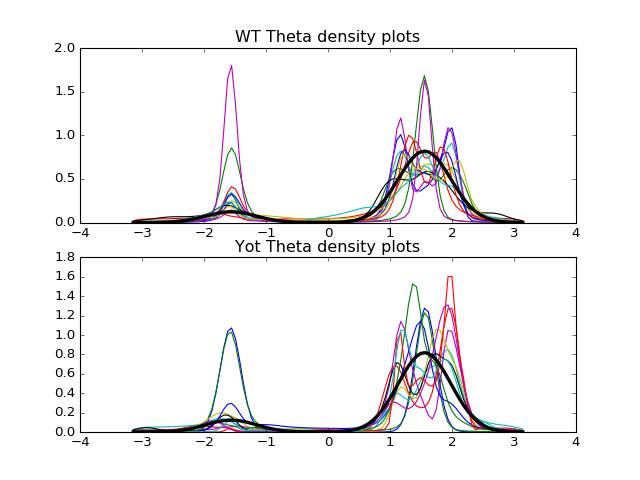

In [49]:
fig = plt.figure()
ax = fig.add_subplot(211)
ay = fig.add_subplot(212,sharex=ax,sharey=ay)

x = np.linspace(-np.pi,np.pi,100)

for kde in theta_kde:
    ax.plot(x,kde)
ax.plot(x,pdfl+pdfr,c='k',linewidth=3)

for kde in ytheta_kde:
    ay.plot(x,kde)
ay.plot(x,pdfl+pdfr,c='k',linewidth=3)

ax.set_title('WT Theta density plots')
ay.set_title('Yot Theta density plots')

## Calculate error by finding area between curves

In [52]:
theta_pdf = pdfl+pdfr

In [53]:
theta_error = []
for kde in theta_kde:
    theta_error.append(simps(theta_pdf-kde,x))

In [54]:
ytheta_error = []
for kde in ytheta_kde:
    ytheta_error.append(simps(theta_pdf-kde,x))

## T Test

In [83]:
ttest_theta = scipy.stats.ttest_ind(theta_error,ytheta_error)
ttest_theta

Ttest_indResult(statistic=-1.0079244950594091, pvalue=0.32397756010470569)

# Arclength

In [32]:
wtrscale = []
for num in wtdf.keys():
    df = wtdf[num]
    mi,ma = df.ac.min(), df.ac.max()
    
    dfmin = df[df.ac < 0]
    dfmax = df[df.ac >= 0]
    
    dfmin = dfmin.join(pd.DataFrame({'ac_scale':dfmin.ac/np.abs(mi)}))
    dfmax = dfmax.join(pd.DataFrame({'ac_scale':dfmax.ac/np.abs(ma)}))
    
    dfout = dfmin.append(dfmax)
    wtrscale.append(dfout)

In [36]:
allrs = pd.concat(wtrscale)

In [33]:
yrscale = []
for num in yotdf.keys():
    df = yotdf[num]
    mi,ma = df.ac.min(), df.ac.max()
    
    dfmin = df[df.ac < 0]
    dfmax = df[df.ac >= 0]
    
    dfmin = dfmin.join(pd.DataFrame({'ac_scale':dfmin.ac/np.abs(mi)}))
    dfmax = dfmax.join(pd.DataFrame({'ac_scale':dfmax.ac/np.abs(ma)}))
    
    dfout = dfmin.append(dfmax)
    yrscale.append(dfout)

In [34]:
kdeabs = []
for df in wtrscale:
    y = np.abs(df.ac_scale.sample(frac=0.01))
    x = np.linspace(y.min(),y.max(),y.size)
    gkde = scipy.stats.gaussian_kde(y)
    kde = gkde.evaluate(x)
    kdeabs.append([x,kde])

In [35]:
ykdeabs = []
for df in yrscale:
    y = np.abs(df.ac_scale.sample(frac=0.01))
    x = np.linspace(y.min(),y.max(),y.size)
    gkde = scipy.stats.gaussian_kde(y)
    kde = gkde.evaluate(x)
    ykdeabs.append([x,kde])

In [39]:
acout = cranium.test_beta(np.abs(allrs.ac_scale.sample(frac=0.01)),'10') 

In [44]:
acout

,b_D,b_a,b_b,b_loc,b_p,b_scale,snum
0,0.046189,1.438426,1.688207,-0.007247,2.019757e-123,1.006581,10


In [42]:
xac = np.linspace(0,1,100)

In [47]:
pdfac = cranium.beta_pdf(xac,[acout.b_a,acout.b_b,acout.b_loc,acout.b_scale])

<IPython.core.display.Javascript object>


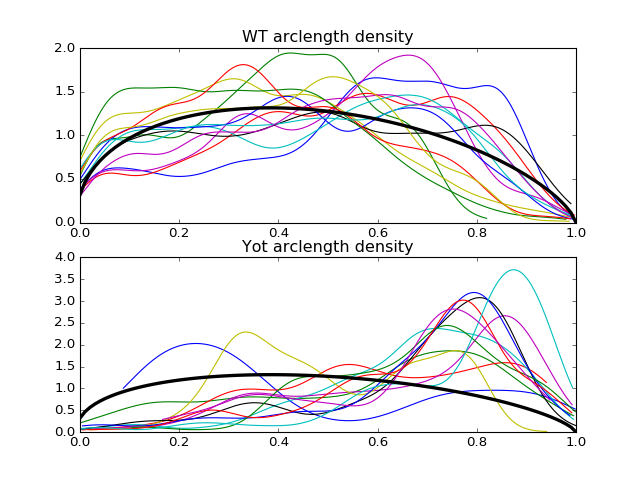

In [51]:
fig = plt.figure()
ax = fig.add_subplot(211)
ay = fig.add_subplot(212)

for kde in kdeabs:
    ax.plot(kde[0],kde[1])
ax.plot(xac,pdfac,c='k',linewidth=3)

for kde in ykdeabs:
    ay.plot(kde[0],kde[1])
ay.plot(xac,pdfac,c='k',linewidth=3)

ax.set_title('WT arclength density')
ay.set_title('Yot arclength density')

## Calculate error

In [66]:
ac_error = []
for kde in kdeabs:
#     print(len(kde[0]))
    ac_error.append(simps(np.abs(cranium.beta_pdf(kde[0],[acout.b_a,acout.b_b,acout.b_loc,acout.b_scale])-kde[1]),kde[0]))
    #ac_error.append(simps(pdfac-kde,xac))

In [67]:
yac_error = []
for kde in ykdeabs:
    yac_error.append(simps(np.abs(cranium.beta_pdf(kde[0],[acout.b_a,acout.b_b,acout.b_loc,acout.b_scale])-kde[1]),kde[0]))

## T test

In [84]:
ttest_ac = scipy.stats.ttest_ind(ac_error,yac_error)
ttest_ac

Ttest_indResult(statistic=-7.5110086326261234, pvalue=1.2437989105730573e-07)

# R

In [73]:
rwtkde = []
for num in wtdf.keys():
    y = wtdf[num].r
    x = np.linspace(0,200,100)
    
    gkde = scipy.stats.gaussian_kde(y)
    kde = gkde.evaluate(x)
    
    rwtkde.append([x,kde])

In [74]:
rykde = []
for num in yotdf.keys():
    y = yotdf[num].r
    x = np.linspace(0,200,100)
    
    gkde = scipy.stats.gaussian_kde(y)
    kde = gkde.evaluate(x)
    
    rykde.append([x,kde])

In [72]:
rparams = cranium.test_gamma(allwt.r.sample(frac=0.01),'10')

In [75]:
xr = np.linspace(0,200,100)

In [76]:
pdfR = cranium.gamma_pdf(xr,[rparams.g_a,rparams.g_loc,rparams.g_scale])

<IPython.core.display.Javascript object>


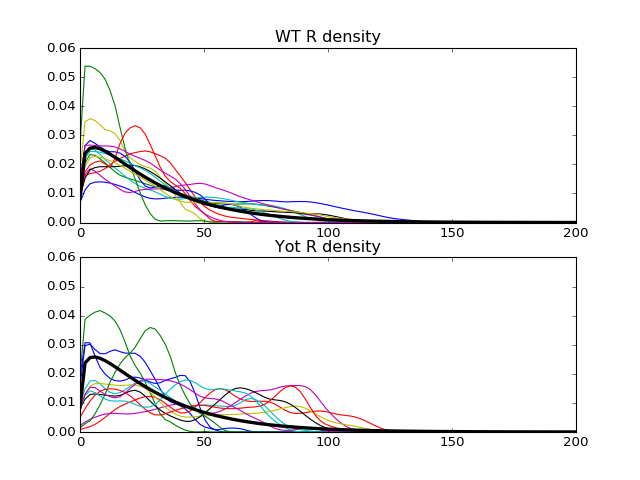

In [79]:
fig = plt.figure()
ax = fig.add_subplot(211)
ay = fig.add_subplot(212,sharex=ax,sharey=ax)

for kde in rwtkde:
    ax.plot(kde[0],kde[1])
ax.plot(xr,pdfR,c='k',linewidth=3)

for kde in rykde:
    ay.plot(kde[0],kde[1])
ay.plot(xr,pdfR,c='k',linewidth=3)

ax.set_title('WT R density')
ay.set_title('Yot R density')

## Calculate error

In [80]:
r_error = []
for kde in rwtkde:
    r_error.append(simps(np.abs(pdfR-kde[1]),kde[0]))

In [81]:
yr_error = []
for kde in rykde:
    yr_error.append(simps(np.abs(pdfR-kde[1]),kde[0]))

# T test

In [85]:
ttest_r = scipy.stats.ttest_ind(r_error,yr_error)
ttest_r

Ttest_indResult(statistic=-3.0274338938123067, pvalue=0.0059912233076694563)

# Conclusions